In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import cv2

import torch
import torchvision
from torchvision import models
from torchvision import transforms

from torch.autograd import Variable
import torch.nn.functional as F

from flashtorch.utils import apply_transforms, load_image 
import net

In [2]:
def custom_transform(pil_image):
    """Custom transform incorporating face alignment and preprocessing."""
    #aligned_rgb_img = align.get_aligned_face(pil_image)
    np_img = np.array(pil_image)
    bgr_img = ((np_img[:, :, ::-1] / 255.0) - 0.5) / 0.5  # Normalize to [-1, 1]
    tensor = torch.tensor(bgr_img.transpose(2, 0, 1)).float()
    return tensor
   

In [3]:
 def get_input_tensors(img):
    
    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.Lambda(lambda img: custom_transform(img)),
    # Add more transformations if needed (e.g., data augmentation)
    ])
    
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)
    

In [4]:
 def get_input_tensors_no_resize(img):
    
    # Define transformations
    transform = transforms.Compose([
    #transforms.Resize((112, 112)),
    transforms.Lambda(lambda img: custom_transform(img)),
    # Add more transformations if needed (e.g., data augmentation)
    ])
    
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)
    

In [5]:
#Define the path to pretrained AdaFace models
adaface_models = {
    'ir_101': "models/adaface_ir101_webface12m.ckpt",
}

def load_pretrained_model(architecture='ir_101'):
    """Load the pretrained AdaFace model."""
    assert architecture in adaface_models.keys(), f"Architecture {architecture} not supported."
    model = net.build_model(architecture)
    statedict = torch.load(adaface_models[architecture])['state_dict']
    # Remove 'model.' prefix from keys
    model_statedict = {key[6:]: val for key, val in statedict.items() if key.startswith('model.')}
    model.load_state_dict(model_statedict)
    model.eval()  # Set to evaluation mode
    return model
    
    
class FaceClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes, freeze_feature_extractor=True):
        super(FaceClassifier, self).__init__()
        self.feature_extractor = load_pretrained_model('ir_101')
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.classifier = nn.Linear(self.feature_dim, self.num_classes)

        if freeze_feature_extractor:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False  # Freeze feature extractor
        #else:
             # Unfreeze the feature extractor
            #for param in self.feature_extractor.parameters():
                #param.requires_grad = True

    def forward(self, x):
        with torch.no_grad():
            features, _ = self.feature_extractor(x)
        #print(features.shape)
        out = self.classifier(features)
        return out

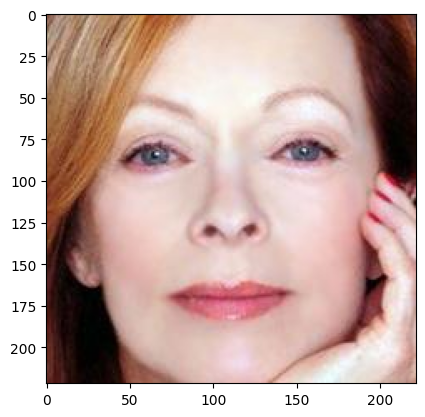

In [6]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = load_image('image_path')

plt.imshow(img)


In [7]:

# check for cuda and set gpu or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
#print(device)


face_model = 'models/facescrub_adamW_webface.pt'
model_f = torch.load(face_model)
model_f.to(device)

img_t = get_input_tensors(img)
img_t_ = img_t.cuda()
model_f.eval()
#print(model_f)

logits = model_f(img_t.cuda())
#print(img_t.device)

/tmp/ipykernel_203549/875531404.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_f = torch.load(face_model)


In [8]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)

In [9]:
print(probs5)

torch.return_types.topk(
values=tensor([[0.9487, 0.0097, 0.0069, 0.0028, 0.0026]], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([[ 39,  74, 511, 429, 453]], device='cuda:0'))


In [10]:
class_names = ['subject_1', 'subject_10', 'subject_100', 'subject_101', 'subject_102', 'subject_103', 'subject_104', 'subject_105', 'subject_106', 'subject_107', 'subject_108', 'subject_109', 'subject_11', 'subject_110', 'subject_111', 'subject_112', 'subject_113', 'subject_114', 'subject_115', 'subject_116', 'subject_117', 'subject_118', 'subject_119', 'subject_12', 'subject_120', 'subject_121', 'subject_122', 'subject_123', 'subject_124', 'subject_125', 'subject_126', 'subject_127', 'subject_128', 'subject_129', 'subject_13', 'subject_130', 'subject_131', 'subject_132', 'subject_133', 'subject_134', 'subject_135', 'subject_136', 'subject_137', 'subject_138', 'subject_139', 'subject_14', 'subject_140', 'subject_141', 'subject_142', 'subject_143', 'subject_144', 'subject_145', 'subject_146', 'subject_147', 'subject_148', 'subject_149', 'subject_15', 'subject_150', 'subject_151', 'subject_152', 'subject_153', 'subject_154', 'subject_155', 'subject_156', 'subject_157', 'subject_158', 'subject_159', 'subject_16', 'subject_160', 'subject_161', 'subject_162', 'subject_163', 'subject_164', 'subject_165', 'subject_166', 'subject_167', 'subject_168', 'subject_169', 'subject_17', 'subject_170', 'subject_171', 'subject_172', 'subject_173', 'subject_174', 'subject_175', 'subject_176', 'subject_177', 'subject_178', 'subject_179', 'subject_18', 'subject_180', 'subject_181', 'subject_182', 'subject_183', 'subject_184', 'subject_185', 'subject_186', 'subject_187', 'subject_188', 'subject_189', 'subject_19', 'subject_190', 'subject_191', 'subject_192', 'subject_193', 'subject_194', 'subject_195', 'subject_196', 'subject_197', 'subject_198', 'subject_199', 'subject_2', 'subject_20', 'subject_200', 'subject_201', 'subject_202', 'subject_203', 'subject_204', 'subject_205', 'subject_206', 'subject_207', 'subject_208', 'subject_209', 'subject_21', 'subject_210', 'subject_211', 'subject_212', 'subject_213', 'subject_214', 'subject_215', 'subject_216', 'subject_217', 'subject_218', 'subject_219', 'subject_22', 'subject_220', 'subject_221', 'subject_222', 'subject_223', 'subject_224', 'subject_225', 'subject_226', 'subject_227', 'subject_228', 'subject_229', 'subject_23', 'subject_230', 'subject_231', 'subject_232', 'subject_233', 'subject_234', 'subject_235', 'subject_236', 'subject_237', 'subject_238', 'subject_239', 'subject_24', 'subject_240', 'subject_241', 'subject_242', 'subject_243', 'subject_244', 'subject_245', 'subject_246', 'subject_247', 'subject_248', 'subject_249', 'subject_25', 'subject_250', 'subject_251', 'subject_252', 'subject_253', 'subject_254', 'subject_255', 'subject_256', 'subject_257', 'subject_258', 'subject_259', 'subject_26', 'subject_260', 'subject_261', 'subject_262', 'subject_263', 'subject_264', 'subject_265', 'subject_266', 'subject_267', 'subject_268', 'subject_269', 'subject_27', 'subject_270', 'subject_271', 'subject_272', 'subject_273', 'subject_274', 'subject_275', 'subject_276', 'subject_277', 'subject_278', 'subject_279', 'subject_28', 'subject_280', 'subject_281', 'subject_282', 'subject_283', 'subject_284', 'subject_285', 'subject_286', 'subject_287', 'subject_288', 'subject_289', 'subject_29', 'subject_290', 'subject_291', 'subject_292', 'subject_293', 'subject_294', 'subject_295', 'subject_296', 'subject_297', 'subject_298', 'subject_299', 'subject_3', 'subject_30', 'subject_300', 'subject_301', 'subject_302', 'subject_303', 'subject_304', 'subject_305', 'subject_306', 'subject_307', 'subject_308', 'subject_309', 'subject_31', 'subject_310', 'subject_311', 'subject_312', 'subject_313', 'subject_314', 'subject_315', 'subject_316', 'subject_317', 'subject_318', 'subject_319', 'subject_32', 'subject_320', 'subject_321', 'subject_322', 'subject_323', 'subject_324', 'subject_325', 'subject_326', 'subject_327', 'subject_328', 'subject_329', 'subject_33', 'subject_330', 'subject_331', 'subject_332', 'subject_333', 'subject_334', 'subject_335', 'subject_336', 'subject_337', 'subject_338', 'subject_339', 'subject_34', 'subject_340', 'subject_341', 'subject_342', 'subject_343', 'subject_344', 'subject_345', 'subject_346', 'subject_347', 'subject_348', 'subject_349', 'subject_35', 'subject_350', 'subject_351', 'subject_352', 'subject_353', 'subject_354', 'subject_355', 'subject_356', 'subject_357', 'subject_358', 'subject_359', 'subject_36', 'subject_360', 'subject_361', 'subject_362', 'subject_363', 'subject_364', 'subject_365', 'subject_366', 'subject_367', 'subject_368', 'subject_369', 'subject_37', 'subject_370', 'subject_371', 'subject_372', 'subject_373', 'subject_374', 'subject_375', 'subject_376', 'subject_377', 'subject_378', 'subject_379', 'subject_38', 'subject_380', 'subject_381', 'subject_382', 'subject_383', 'subject_384', 'subject_385', 'subject_386', 'subject_387', 'subject_388', 'subject_389', 'subject_39', 'subject_390', 'subject_391', 'subject_392', 'subject_393', 'subject_394', 'subject_395', 'subject_396', 'subject_397', 'subject_398', 'subject_399', 'subject_4', 'subject_40', 'subject_400', 'subject_401', 'subject_402', 'subject_403', 'subject_404', 'subject_405', 'subject_406', 'subject_407', 'subject_408', 'subject_409', 'subject_41', 'subject_410', 'subject_411', 'subject_412', 'subject_413', 'subject_414', 'subject_415', 'subject_416', 'subject_417', 'subject_418', 'subject_419', 'subject_42', 'subject_420', 'subject_421', 'subject_422', 'subject_423', 'subject_424', 'subject_425', 'subject_426', 'subject_427', 'subject_428', 'subject_429', 'subject_43', 'subject_430', 'subject_431', 'subject_432', 'subject_433', 'subject_434', 'subject_435', 'subject_436', 'subject_437', 'subject_438', 'subject_439', 'subject_44', 'subject_440', 'subject_441', 'subject_442', 'subject_443', 'subject_444', 'subject_445', 'subject_446', 'subject_447', 'subject_448', 'subject_449', 'subject_45', 'subject_450', 'subject_451', 'subject_452', 'subject_453', 'subject_454', 'subject_455', 'subject_456', 'subject_457', 'subject_458', 'subject_459', 'subject_46', 'subject_460', 'subject_461', 'subject_462', 'subject_463', 'subject_464', 'subject_465', 'subject_466', 'subject_467', 'subject_468', 'subject_469', 'subject_47', 'subject_470', 'subject_471', 'subject_472', 'subject_473', 'subject_474', 'subject_475', 'subject_476', 'subject_477', 'subject_478', 'subject_479', 'subject_48', 'subject_480', 'subject_481', 'subject_482', 'subject_483', 'subject_484', 'subject_485', 'subject_486', 'subject_487', 'subject_488', 'subject_489', 'subject_49', 'subject_490', 'subject_491', 'subject_492', 'subject_493', 'subject_494', 'subject_495', 'subject_496', 'subject_497', 'subject_498', 'subject_499', 'subject_5', 'subject_50', 'subject_500', 'subject_501', 'subject_502', 'subject_503', 'subject_504', 'subject_505', 'subject_506', 'subject_507', 'subject_508', 'subject_509', 'subject_51', 'subject_510', 'subject_511', 'subject_512', 'subject_513', 'subject_514', 'subject_515', 'subject_516', 'subject_517', 'subject_518', 'subject_519', 'subject_52', 'subject_520', 'subject_521', 'subject_522', 'subject_523', 'subject_524', 'subject_525', 'subject_526', 'subject_527', 'subject_528', 'subject_529', 'subject_53', 'subject_530', 'subject_54', 'subject_55', 'subject_56', 'subject_57', 'subject_58', 'subject_59', 'subject_6', 'subject_60', 'subject_61', 'subject_62', 'subject_63', 'subject_64', 'subject_65', 'subject_66', 'subject_67', 'subject_68', 'subject_69', 'subject_7', 'subject_70', 'subject_71', 'subject_72', 'subject_73', 'subject_74', 'subject_75', 'subject_76', 'subject_77', 'subject_78', 'subject_79', 'subject_8', 'subject_80', 'subject_81', 'subject_82', 'subject_83', 'subject_84', 'subject_85', 'subject_86', 'subject_87', 'subject_88', 'subject_89', 'subject_9', 'subject_90', 'subject_91', 'subject_92', 'subject_93', 'subject_94', 'subject_95', 'subject_96', 'subject_97', 'subject_98', 'subject_99']


In [13]:

import io 

import scipy.ndimage as nd 

from flashtorch.saliency import Backprop 
from flashtorch.activmax import GradientAscent 

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')




In [14]:

class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()


In [15]:

def get_class_cam(model, _, activations, class_index):
    
    out_features = activations.output.squeeze(0)
    out_features = np.transpose(out_features.cpu().detach(), (1,2,0))
    fw = model.classifier.weight[class_index,:]
    cam = np.dot(out_features.detach(), fw.detach().cpu())
    return cam


In [16]:


def get_score_cam(model, input_tensor, target_class, activations):
    """
    Generate Score-CAM for a specific class.
    
    Args:
        model (torch.nn.Module): The classification model.
        input_tensor (torch.Tensor): Input image tensor of shape (1, C, H, W).
        target_class (int): The target class index.
        activations: Hook object containing feature maps from the target layer.

    Returns:
        np.ndarray: Score-CAM heatmap.
    """
    with torch.no_grad():
        # Get activation maps from hook (shape: [C, H, W])
        act = activations.output.squeeze(0)  # Remove batch dim
        num_channels, h, w = act.shape

        # Normalize activation maps to [0, 1]
        min_vals = torch.amin(act, dim=(1, 2), keepdim=True)
        max_vals = torch.amax(act, dim=(1, 2), keepdim=True)
        act = (act - min_vals) / (max_vals - min_vals + 1e-8)

        # Resize each activation map to input size (H, W)
        _, _, H, W = input_tensor.shape
        upsampled_acts = F.interpolate(act.unsqueeze(0), size=(H, W), mode='bilinear', align_corners=False)
        
        weights = []
        for i in range(num_channels):
            masked_input = input_tensor * upsampled_acts[0, i:i+1, :, :]
            output = model(masked_input)
            score = F.softmax(output, dim=1)[0, target_class].item()
            weights.append(score)
        
        weights = np.array(weights).reshape(-1, 1, 1)
        cam = (act.cpu().numpy() * weights).sum(axis=0)

        cam = np.maximum(cam, 0)  # ReLU
        #cam = cam - np.min(cam)
        #cam = cam / (np.max(cam) + 1e-8)  # Normalize to [0, 1]
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)
        return cam


In [18]:
def show_sub_plots_op(original, activations, pclasses):
    n = len(activations)
    f, axarr = plt.subplots(1, n, figsize=(n * 5, 5))
    
    # Reverse the custom transformation to display the original image properly
    inp = torch.squeeze(original, 0).numpy().transpose((1, 2, 0))  # Change to (H, W, C)
    inp = ((inp * 0.5) + 0.5) * 255  # De-normalize from [-1, 1] to [0, 255]
    inp = inp[:, :, ::-1]  # Convert back from BGR to RGB
    inp = np.clip(inp / 255.0, 0, 1)  # Normalize to [0, 1] for display
    
    # Display each activation map with the original image as background
    for i, cam in enumerate(activations):
        axarr[i].axis('off')
        axarr[i].imshow(inp, cmap='jet', alpha=1)
        axarr[i].set_title(pclasses[i])
        
        # Calculate zoom factor based on the original and cam dimensions
        orig_h, orig_w = inp.shape[:2]
        
        print("image_shape:",inp.shape[:2])
        print("cam_shape:",cam.shape)
        
        cam_h, cam_w = cam.shape
        zoom_factor = (orig_h / cam_h, orig_w / cam_w)
        
        # Rescale the activation map
        zcam = nd.zoom(cam, zoom=zoom_factor, order=1)
        
        #heatmap = cv2.resize(cam, (inp.shape[1], inp.shape[0])) 
        axarr[i].imshow(zcam, cmap='jet', alpha=0.4)
    
    # Add a short pause for the plot to render
    plt.pause(0.001)


/tmp/ipykernel_203549/4172544629.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(SDD_Model)


CAM 0: 
 [[-1.7738447  -2.272411   -0.8740301  -0.9635937  -3.517572   -2.5338767
  -1.3022246 ]
 [ 0.72691244  0.33967713 -3.138854   -5.268809    1.3114315  -2.2561135
  -1.4802482 ]
 [ 0.03969127 -0.46145985 -4.728112   -2.9855516  -2.5478606   6.5434194
   4.864786  ]
 [-0.49691048 -0.5346642  -2.0187721   0.86313206 -2.8503048   3.259769
   0.1000689 ]
 [ 0.21763703  3.0284276   3.4759798   7.7131896   6.4559326  -5.027852
   3.3565757 ]
 [-1.7290722   6.7583313   3.5156014   0.41081697 -0.6153041  -1.83407
   1.8771635 ]
 [ 0.65632576  0.4957095   1.0098283   1.1167727   2.722652    3.7158089
   1.3520302 ]]
(7, 7)
CAM 1: 
 [[ 0.17647721 -5.8666544  -3.954337   -4.37719    -2.8515847  -3.9384437
  -0.76016116]
 [ 2.1778696   0.48709694  4.6851907  -0.63633764  8.557716    5.3143835
  -1.3852026 ]
 [-0.71758294 -4.355094    1.1560329  -0.85159004  3.1899488   1.0738262
   1.7957438 ]
 [ 2.2881665  -2.5112498   4.730367    3.1487114   6.1128254   0.90128016
   3.4556086 ]
 [-3.7888

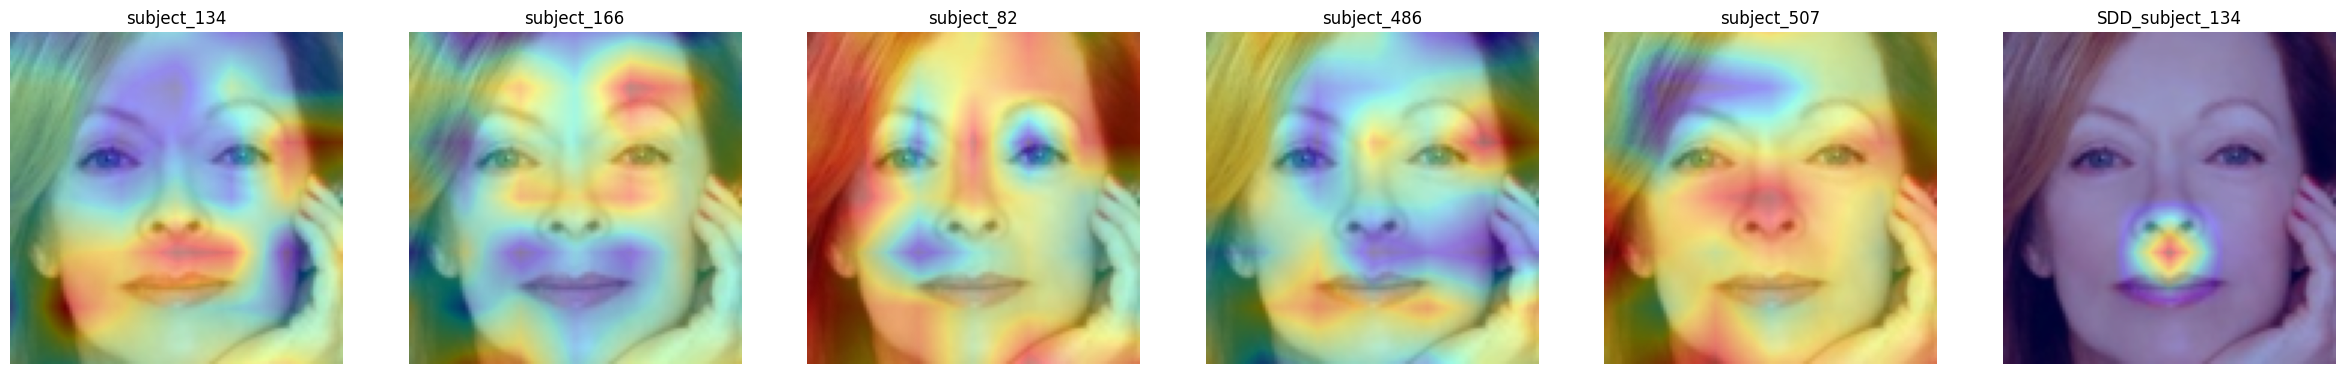

In [41]:


SDD_Model = 'models/facescrub_adamW_webface.pt'
#COVID_MODEL = 'models/xrayModel.pt'
# COVID_MODEL = 'models/resnetCovidNet.pt'
model = torch.load(SDD_Model)
#model = torchvision.models.resnet152(pretrained=True)

model.to(device)
model.eval()
  
#target_class = 2
   

hook = Hook(model.feature_extractor.body[48].res_layer[4])
output = model(img_t.cuda())

cams = []
pclasses = []

# Iterate over the top 5 classes and generate CAM for each
for i in range(5):
    class_index = probs5.indices[0, i].item()  # Get the class index for the top-i prediction
    #cam = get_score_cam(model, img_t_, class_index, hook)
    cam = get_class_cam(model, output, hook, class_index)  # Generate CAM for this class
    #cam = np.maximum(cam, 0)
    #cam_norm = cam / cam.max()
    cams.append(cam)
    
    # Append the corresponding class name from 'class_names'
    pclasses.append(class_names[class_index])

# Now 'cams' contains the CAMs for the top 5 classes,
# and 'pclasses' contains the corresponding subject names.
    

   
print("CAM 0: \n", cams[0])
print(cams[0].shape)
print('CAM 1: \n', cams[1])
print('CAM 2: \n', cams[2])
#scale = 5 * (np.mean([cam.mean() for cam in cams[1:]]) / cams[0].mean())
scale = 5 * (np.mean([np.abs(cam).mean() for cam in cams[1:]]) / np.abs(cams[0]).mean())
scale = np.clip(scale, 5, 50)
print("Scale:", scale)
cams[0] = cams[0] * scale
diff = cams[0] - cams[1]
diff = diff - cams[2]
diff = diff - cams[3]
diff = diff - cams[4]
#diff = np.exp(0.2 * diff)
# Compute differences
#diff = cams[0] - np.mean(cams[1:], axis=0)

# Compute dynamic exponential factor
std_dev = np.std(diff)
factor = 0.2 + (std_dev / (std_dev + 1)) * 0.2  # Adaptive factor based on spread

# Apply exponential
diff = np.exp(factor * diff)




cams.append(diff)

pclasses.append("SDD_" + pclasses[0])

original = img_t.detach().cpu()
show_sub_plots_op(original, cams, pclasses)


plt.show()
    
pclass = "SDD_CAM"
    




In [21]:


def apply_mask(image, heatmap, mask_type='black', threshold=np.percentile(diff, 80)):
 
     
 
    image = np.array(image)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to image size
    mask = heatmap > threshold  # Create a binary mask of important regions
    
    
    
    # Apply masking
    perturbed_image = image.copy()
    if mask_type == 'black':
        perturbed_image[mask] = 0  # Set important regions to black
    elif mask_type == 'mean':
        mean_pixel_value = np.mean(image, axis=(0, 1), keepdims=True)
        perturbed_image[mask] = mean_pixel_value  # Set important regions to mean pixel value
    elif mask_type == 'blur':
        blurred = cv2.GaussianBlur(image, (21, 21), 0)
        perturbed_image[mask] = blurred[mask]  # Apply blur to important regions
    
    pil_image = Image.fromarray(perturbed_image.astype('uint8'))
    return pil_image


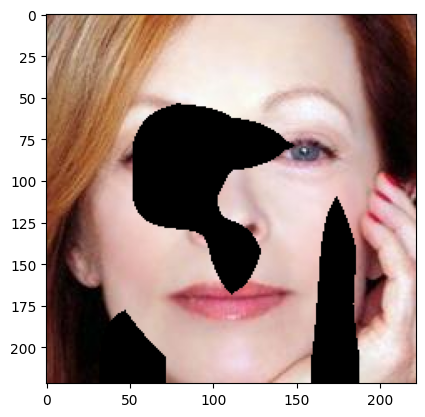

In [22]:
perturbed_image = apply_mask(img, diff)

plt.imshow(perturbed_image)



perturbed_image_t = get_input_tensors(perturbed_image)






In [26]:
def shift_mask(mask, shift_y, shift_x):
    """
    Shifts the mask by given offsets. Wraps around if necessary.
    
    Args:
        mask: Input binary mask (2D array).
        shift_y: Vertical shift (positive for down, negative for up).
        shift_x: Horizontal shift (positive for right, negative for left).
    
    Returns:
        Shifted mask of the same size.
    """
    # Perform shift with wrapping using np.roll
    shifted_mask = np.roll(mask, shift_y, axis=0)  # Shift vertically
    shifted_mask = np.roll(shifted_mask, shift_x, axis=1)  # Shift horizontally
    return shifted_mask


def shift_mask_new(mask, shift_y, shift_x):
    """
    Shifts the mask by given offsets, ensuring no part of the mask extends outside the image boundaries.
    
    Args:
        mask: Input binary mask (2D array).
        shift_y: Vertical shift (positive for down, negative for up).
        shift_x: Horizontal shift (positive for right, negative for left).
    
    Returns:
        Shifted mask of the same size.
    """
    h, w = mask.shape
    shifted_mask = np.zeros_like(mask)  # Initialize the output mask with zeros

    # Compute the valid region for the source and destination
    src_y_start = max(0, shift_y)
    src_y_end = min(h, h + shift_y)
    dest_y_start = max(0, -shift_y)
    dest_y_end = min(h, h - shift_y)

    src_x_start = max(0, shift_x)
    src_x_end = min(w, w + shift_x)
    dest_x_start = max(0, -shift_x)
    dest_x_end = min(w, w - shift_x)

    # Place the mask in the new position without extending
    shifted_mask[dest_y_start:dest_y_end, dest_x_start:dest_x_end] = mask[src_y_start:src_y_end, src_x_start:src_x_end]

    return shifted_mask


def apply_mask_random_new(image, heatmap, mask_type='black', threshold=np.percentile(diff, 80)):
    """
    Mask the image based on the Grad-CAM heatmap.
    Arguments:
    - image: Original input image (numpy array)
    - heatmap: Grad-CAM heatmap (numpy array)
    - mask_type: Type of masking ('black', 'blur', or 'mean')
    """
     
    #T_R = transforms.Resize((112, 112))
    #image = T_R(image)   
    # Convert the PIL image to a numpy array
    image = np.array(image)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to image size
    mask = heatmap > threshold  # Create a binary mask of important regions
    
    # Generate random shifts
    np.random.seed(42)
    #shift_y = np.random.randint(-mask.shape[0] // 2, mask.shape[0] // 2)
    #shift_x = np.random.randint(-mask.shape[1] // 2, mask.shape[1] // 2)
    
    shift_y = np.random.randint(-image.shape[0], image.shape[0])
    shift_x = np.random.randint(-image.shape[1], image.shape[1])
    

    # Shift the mask
    shifted_mask = shift_mask(mask, shift_y, shift_x)
    
    # Apply masking
    perturbed_image = image.copy()
    if mask_type == 'black':
        perturbed_image[shifted_mask] = 0  # Set important regions to black
    elif mask_type == 'mean':
        mean_pixel_value = np.mean(image, axis=(0, 1), keepdims=True)
        perturbed_image[mask] = mean_pixel_value  # Set important regions to mean pixel value
    elif mask_type == 'blur':
        blurred = cv2.GaussianBlur(image, (21, 21), 0)
        perturbed_image[mask] = blurred[mask]  # Apply blur to important regions
    
    pil_image = Image.fromarray(perturbed_image.astype('uint8'))
    return pil_image


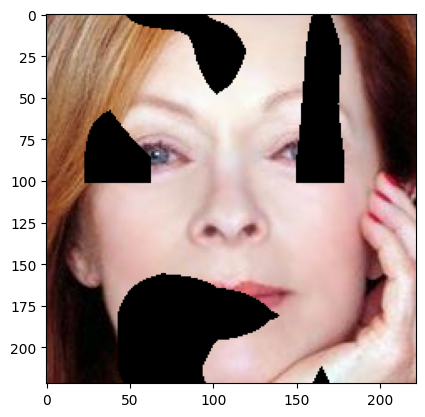

In [27]:
random_image = apply_mask_random_new(img, diff)
plt.imshow(random_image)

random_image_t = get_input_tensors(random_image)

In [29]:
target_class = probs5.indices[0, 0].item() 
print(target_class)

39


In [30]:
def evaluate_confidence_drop(model, device, original_image, perturbed_image, target_class):
    """
    Measure the drop in confidence between the original and perturbed image.
    Arguments:
    - model: Trained model
    - original_image: Original input image (tensor)
    - perturbed_image: Image with masked important regions (tensor)
    - target_class: Target class for the prediction
    """
    model.to(device)
    model.eval()

    # Original confidence
    original_output = model(original_image.cuda())
    original_confidence = torch.softmax(original_output, dim=1)[0, target_class].item()

    # Perturbed confidence
    perturbed_output = model(perturbed_image.cuda())
    perturbed_confidence = torch.softmax(perturbed_output, dim=1)[0, target_class].item()

    # Calculate confidence drop
    confidence_drop = original_confidence - perturbed_confidence
    return confidence_drop


In [31]:
SDD_confidence_drop = evaluate_confidence_drop(model, device, img_t, perturbed_image_t, target_class)
print(SDD_confidence_drop)

0.9099699556827545


In [32]:
random_confidence_drop = evaluate_confidence_drop(model, device, img_t, random_image_t, target_class)
print(random_confidence_drop)

0.22067677974700928


In [33]:
def only_mask_sdd(image, heatmap, threshold=np.percentile(diff, 80)):
    """
    Mask the image based on the Grad-CAM heatmap.
    Arguments:
    - image: Original input image (numpy array)
    - heatmap: Grad-CAM heatmap (numpy array)
    - mask_type: Type of masking ('black', 'blur', or 'mean')
    """
    # Convert to NumPy array
    image = np.array(image)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Create a binary mask
    mask = heatmap > threshold

    # Ensure the image is a proper copy
    perturbed_image = np.copy(image)

    # Initialize the result image with black
    result = np.zeros_like(perturbed_image)

  

    # Copy the mask region to the result
    result[mask] = perturbed_image[mask]
    
    
    pil_image = Image.fromarray(result.astype('uint8'))
    return pil_image


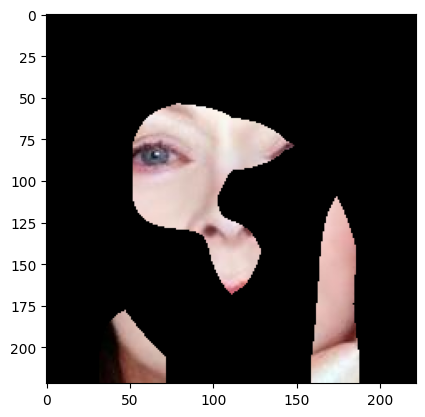

In [34]:
sdd_image = only_mask_sdd(img, diff)

plt.imshow(sdd_image)



sdd_image_t = get_input_tensors(sdd_image)

In [35]:
def only_mask_random(image, heatmap, threshold=np.percentile(diff, 80)):
    """
    Mask the image based on the Grad-CAM heatmap.
    Arguments:
    - image: Original input image (numpy array)
    - heatmap: Grad-CAM heatmap (numpy array)
    - mask_type: Type of masking ('black', 'blur', or 'mean')
    """
     
   
    # Convert the PIL image to a numpy array
    image = np.array(image)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap to image size
    mask = heatmap > threshold  # Create a binary mask of important regions
    
    # Generate random shifts
    np.random.seed(42)
    #shift_y = np.random.randint(-mask.shape[0] // 2, mask.shape[0] // 2)
    #shift_x = np.random.randint(-mask.shape[1] // 2, mask.shape[1] // 2)
    
    shift_y = np.random.randint(-image.shape[0], image.shape[0])
    shift_x = np.random.randint(-image.shape[1], image.shape[1])
    

    # Shift the mask
    shifted_mask = shift_mask(mask, shift_y, shift_x)
    
     # Ensure the image is a proper copy
    perturbed_image = np.copy(image)

    # Initialize the result image with black
    result = np.zeros_like(perturbed_image)

  

    # Copy the mask region to the result
    result[shifted_mask] = perturbed_image[shifted_mask]
    
    
    pil_image = Image.fromarray(result.astype('uint8'))
    return pil_image



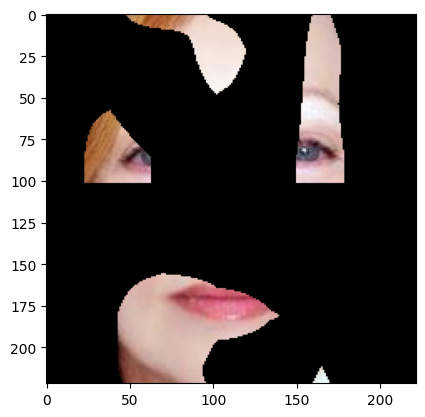

In [36]:
random_mask_image = only_mask_random(img, diff)

plt.imshow(random_mask_image)



random_mask_image_t = get_input_tensors(random_mask_image)

In [37]:
SDD_mask_confidence_drop = evaluate_confidence_drop(model, device, img_t, sdd_image_t, target_class)
print(SDD_mask_confidence_drop)

0.9397946624085307


In [38]:
random_mask_confidence_drop = evaluate_confidence_drop(model, device, img_t, random_mask_image_t, target_class)
print(random_mask_confidence_drop)

0.9414146798662841
